In [11]:
import torch
from pykan.kan.spline import curve2coef, coef2curve, B_batch
from torch import nn

import numpy as np
from tqdm import tqdm

In [36]:
class LAN_layer(nn.Module):
    def __init__(
        self,
        dim=2,
        num=5,
        k=3,
        noise_scale=0.1,
        scale_base=1.0,
        scale_sp=1.0,
        base_fun=torch.nn.SiLU(),
        grid_eps=0.02,
        grid_range=[-1,1],
        sp_trainable=True,
        sb_trainable=True,
        device='cpu'
    ):
        super().__init__()

        self.dim = dim
        self.num = num
        self.k = k 
        self.base_fun = base_fun
        self.device = device

        # определить grid
        self.grid = torch.einsum('i,j->ij', torch.ones(self.dim, device=device), torch.linspace(grid_range[0], grid_range[1], steps=num + 1, device=device))
        self.grid = torch.nn.Parameter(self.grid).requires_grad_(False)

        noises = (torch.rand(self.dim, self.grid.shape[1]) - 1 / 2) * noise_scale / num
        noises = noises.to(device)
        # shape: (size, coef)
        self.coef = torch.nn.Parameter(curve2coef(self.grid, noises, self.grid, k, device))

    def forward(self, x):
        # (batch, dim) -> (dim, batch)
        x = x.permute(1, 0)
        y = coef2curve(x_eval=x, grid=self.grid, coef=self.coef, k=self.k, device=self.device).permute(1, 0)  # shape (batch, dim)
        return y
    
    # def update_grid_from_samples(self, x):
    #     batch = x.shape[0]
    #     x = torch.einsum('ij,k->ikj', x, torch.ones(self.dim, ).to(self.device)).reshape(batch, self.size).permute(1, 0)
    #     x_pos = torch.sort(x, dim=1)[0]
    #     y_eval = coef2curve(x_pos, self.grid, self.coef, self.k, device=self.device)
    #     num_interval = self.grid.shape[1] - 1
    #     ids = [int(batch / num_interval * i) for i in range(num_interval)] + [-1]
    #     grid_adaptive = x_pos[:, ids]
    #     margin = 0.01
    #     grid_uniform = torch.cat([grid_adaptive[:, [0]] - margin + (grid_adaptive[:, [-1]] - grid_adaptive[:, [0]] + 2 * margin) * a for a in np.linspace(0, 1, num=self.grid.shape[1])], dim=1)
    #     self.grid.data = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
    #     self.coef.data = curve2coef(x_pos, y_eval, self.grid, self.k, device=self.device)

In [37]:
device = 'cuda'

In [38]:
from pykan.kan.utils import create_dataset

f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [85]:
num = 10

model = nn.Sequential(
    nn.Linear(2, 5).requires_grad_(False),
    nn.BatchNorm1d(5).requires_grad_(False),
    
    LAN_layer(5, num=num, grid_range=[-10, 10], device=device),

    nn.Linear(5, 10).requires_grad_(False),
    nn.BatchNorm1d(10).requires_grad_(False),

    LAN_layer(10, num=num, grid_range=[-10, 10], device=device),

    nn.Linear(10, 5).requires_grad_(False),
    nn.BatchNorm1d(5).requires_grad_(False),

    LAN_layer(5, num=num, grid_range=[-10, 10], device=device),

    nn.Linear(5, 1).requires_grad_(False),
).to(device)

In [89]:
batch_size = 512
batch_size_test = 512
steps = 1000

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = loss_fn_eval = lambda x, y: torch.mean((x - y) ** 2)

In [90]:

pbar = tqdm(range(steps), desc='description', ncols=100)

test_losses = []
train_losses = []

for _ in pbar:

        train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
        test_id = np.random.choice(dataset['test_input'].shape[0], batch_size_test, replace=False)

        # if _ % grid_update_freq == 0 and _ < stop_grid_update_step and update_grid:
        #     self.update_grid_from_samples(dataset['train_input'][train_id].to(device))


        pred = model(dataset['train_input'][train_id].to(device)) 
        train_loss = loss_fn(pred, dataset['train_label'][train_id].to(device))
        loss = train_loss
        # reg_ = reg(self.acts_scale)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        test_loss = loss_fn_eval(model(dataset['test_input'][test_id].to(device)), dataset['test_label'][test_id].to(device))

        if _ % 100 == 0:
                pbar.set_description("train loss: %.2e | test loss: %.2e" % (torch.sqrt(train_loss).cpu().detach().numpy(), torch.sqrt(test_loss).cpu().detach().numpy()))
        test_losses.append(test_loss.item())
        train_losses.append(train_loss.item())


train loss: 2.03e+00 | test loss: 2.04e+00: 100%|███████████████| 1000/1000 [00:10<00:00, 97.39it/s]


In [91]:
import matplotlib.pyplot as plt

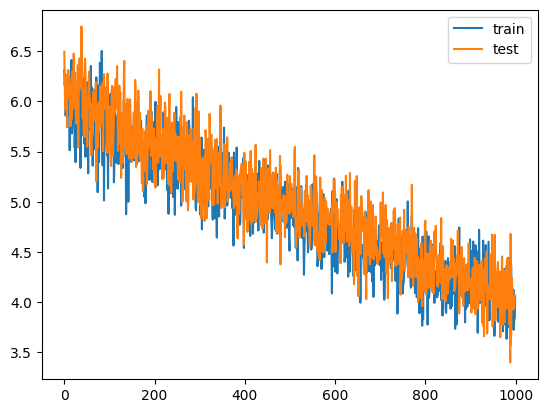

In [92]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()